If you want to visualize other operator problems, modify the operator_type variable.

In [1]:
operator_type = "Burgers" # "RDiffusion" "Advection" "Burgers" "Identity" "Darcy"

## 1. Data Loading and Preprocessing

In [2]:
from visualization.visualization_PDE_utils import *
warnings.filterwarnings('ignore')

config_files = list(Path("data").glob(f"{operator_type}_Operator_config_*.json"))
if not config_files:
    print("❌ 未找到配置文件!")

latest_config = max(config_files, key=os.path.getctime)
with open(latest_config, 'r') as f:
    config = json.load(f)

data_file_path = f"data/{operator_type}_Operator_data/{operator_type}_Operator_data_{config['num_points']}_1.npz"

# 加载数据
print("正在加载数据...")
data = np.load(data_file_path)

# 提取数据
u0_data = data['u0_cals']  # 初始条件
u_data = data['u_cals']    # 真实解

# 检查数据形状并进行必要的调整
if len(u_data.shape) == 3:
    print(f"  检测到3D数据格式: (样本数, 空间, 时间)")
    if u_data.shape[1] != u_data.shape[2]:
        print(f"  注意：空间维度({u_data.shape[1]})与时间维度({u_data.shape[2]})不一致")
elif len(u_data.shape) == 2:
    print(f"  检测到2D数据格式，可能需要reshape")
    
# 确保数据形状一致性
num_samples = u_data.shape[0]
print(f"  总样本数: {num_samples}")

# 创建结果保存目录
save_path = f"visualization_results/{config['model_type']}/{operator_type}_Operator_results"
os.makedirs(save_path, exist_ok=True)
print(f"结果将保存在: {save_path}/")

data.close()

/mnt/nas-new/home/yange/wangruocheng/mindquan/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[ERROR] ME(575878:140433026819904,MainProcess):2025-08-14-21:48:13.627.630 [mindspore/run_check/_check_version.py:230] Cuda ['10.1', '11.1', '11.6'] version(libcudnn*.so need by mindspore-gpu) is not found. Please confirm that the path of cuda is set to the env LD_LIBRARY_PATH, or check whether the CUDA version in wheel package and the CUDA runtime in current device matches. Please refer to the installation guidelines: https://www.mindspore.cn/install


正在加载数据...
  检测到3D数据格式: (样本数, 空间, 时间)
  总样本数: 2000
结果将保存在: visualization_results/QuanONet/Burgers_Operator_results/


## 2. Model Loading and Setup

In [3]:
# 导入模型相关的模块
try:
    from core.models import QuanONet
    from core.quantum_circuits import generate_simple_hamiltonian
    print("✅ 成功导入QuanONet模型")
except ImportError as e:
    print(f"❌ 导入模型失败: {e}")
    raise

# 设置MindSpore环境
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")


def load_trained_model(config):
    """加载训练好的模型"""
    # 查找最佳模型文件
    best_model_path = f"checkpoints/best_{operator_type}_QuanONet.ckpt"
    
    if not os.path.exists(best_model_path):
        print(f"❌ 模型文件不存在: {best_model_path}")
        print("将使用随机初始化的模型进行演示")
        model_exists = False
    else:
        print(f"✅ 找到模型文件: {best_model_path}")
        model_exists = True
    
    # 创建模型
    try:
        ham = generate_simple_hamiltonian(config['num_qubits'])                                     
        branch_input_size = config['branch_input_size']
        trunk_input_size = config['trunk_input_size']
        
        model = QuanONet(
            num_qubits=config['num_qubits'],
            branch_input_size=branch_input_size,
            trunk_input_size=trunk_input_size,
            net_size=tuple(config['net_size']),
            ham=ham,
            scale_coeff=config['scale_coeff'],
            if_trainable_freq=config.get('if_trainable_freq', False)
        )
        
        # 如果模型文件存在，加载权重
        if model_exists:
            try:
                param_dict = load_checkpoint(best_model_path)
                # 注意：由于我们改变了branch_input_size，可能无法直接加载权重
                # 这里我们尝试加载，如果失败就使用随机初始化
                load_param_into_net(model, param_dict, strict_load=False)
                print(f"✅ 模型权重加载成功 (可能部分参数不匹配)")
            except Exception as e:
                print(f"⚠️ 模型权重加载失败，使用随机初始化: {e}")
        else:
            print("⚠️ 使用随机初始化的模型")
        
        model.set_train(False)  # 设置为评估模式
        print(f"✅ 模型创建成功: {config['model_type']}")
        
        return model
        
    except Exception as e:
        print(f"❌ 模型创建失败: {e}")
        return None

# 加载模型
model = load_trained_model(config)
if model is not None:
    print("模型加载完成，准备进行预测")
else:
    print("模型加载失败")

✅ 成功导入QuanONet模型
✅ 找到模型文件: checkpoints/best_Burgers_QuanONet.ckpt
✅ 模型权重加载成功 (可能部分参数不匹配)
✅ 模型创建成功: QuanONet
模型加载完成，准备进行预测


## 3. Generate Prediction Results

In [4]:
# 从数据集中采样两组样本进行分析
sample_indices = [0, 1]  # 选择两个样本进行对比
num_samples = len(sample_indices)

print(f"正在处理 {num_samples} 个样本: {sample_indices}")

# 检查数据的实际分辨率
sample_u_data = u_data[0]
if len(sample_u_data.shape) == 2:
    actual_resolution_x, actual_resolution_t = sample_u_data.shape
    print(f"数据集实际分辨率: {actual_resolution_x} x {actual_resolution_t}")
else:
    print(f"数据格式异常: {sample_u_data.shape}")
    actual_resolution_x = actual_resolution_t = config['num_points']  # 使用默认值

# 使用数据集的实际分辨率，不进行下采样
num_x = actual_resolution_x  # 空间点数
num_t = actual_resolution_t  # 时间点数

print(f"使用数据集原始分辨率: {num_x} x {num_t}")

# 创建空间坐标 (假设空间范围为 [0, 1])
x_coords = np.linspace(0, 1, num_x)
# 创建时间坐标 (假设时间范围为 [0, 1])  
t_coords = np.linspace(0, 1, num_t)

# 为模型预测准备数据
results = []


for i, sample_idx in enumerate(sample_indices):
    
    # 获取初始条件和真实解
    u0_sample = u0_data[sample_idx]  # shape: 根据数据集实际形状
    u_true_sample = u_data[sample_idx]  # shape: 根据数据集实际形状
    # 模型预测
    u_pred_sample = generate_predictions_mindspore(model, u0_sample, num_points=config['num_points'])
    
    # 存储结果
    result = {
        'sample_idx': sample_idx,
        'u0': u0_sample,
        'u_true': u_true_sample,
        'u_pred': u_pred_sample,
        'x_coords': x_coords,
        't_coords': t_coords
    }
    results.append(result)

print(f"所有样本预测完成!")

正在处理 2 个样本: [0, 1]
数据集实际分辨率: 100 x 100
使用数据集原始分辨率: 100 x 100
所有样本预测完成!


## 4. Generate Visualization Results

开始生成可视化结果...

1. 生成样本对比图 (四子图布局)...


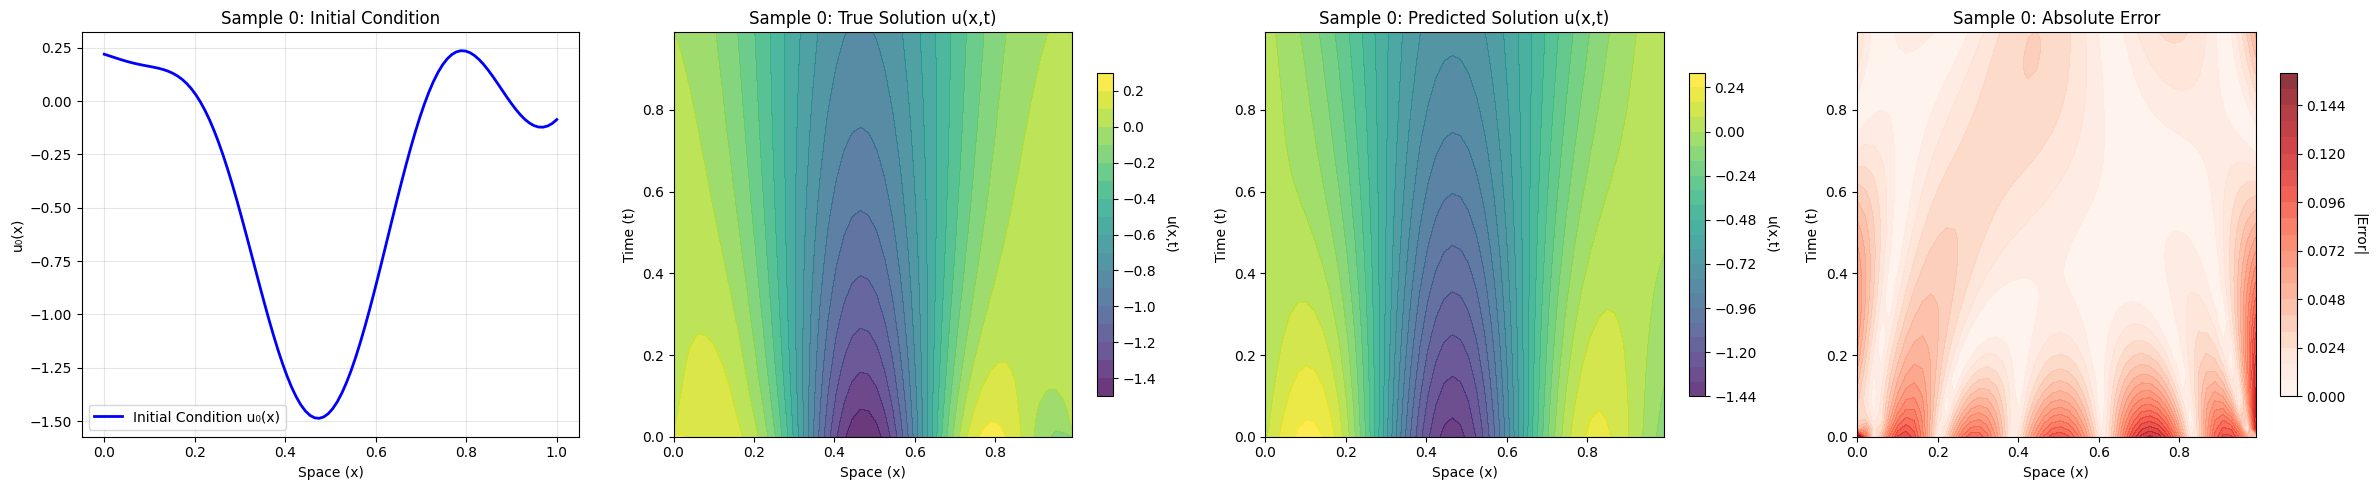

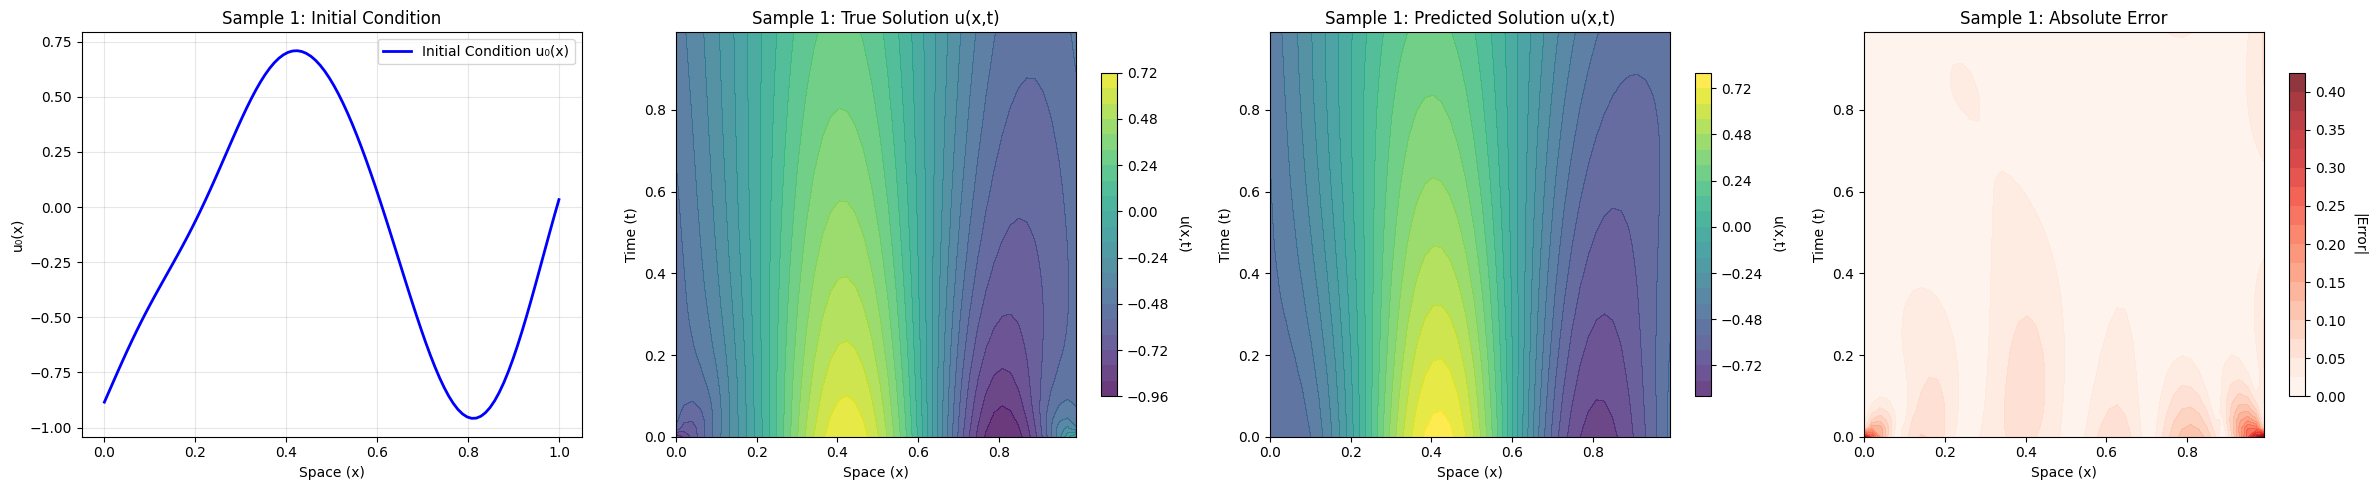


2. 统计摘要:
样本 0: MSE=0.000912, MAE=0.021677, 最大误差=0.185415
样本 1: MSE=0.001048, MAE=0.022276, 最大误差=0.465722

整体统计: MSE=0.000980, MAE=0.021977, 最大误差=0.465722

结果已保存在: visualization_results/QuanONet/Burgers_Operator_results/
可视化分析完成!


In [5]:
# 生成可视化结果
print("开始生成可视化结果...")

# 1. 为每个样本生成对比图 (包含误差热图)
print("\n1. 生成样本对比图 (四子图布局)...")
for result in results:
    sample_idx = result['sample_idx']
    plot_comparison(result, save_path)

# 2. 生成统计摘要
print("\n2. 统计摘要:")
print("="*50)

for i, result in enumerate(results):
    sample_idx = result['sample_idx']
    u_true = result['u_true']
    u_pred = result['u_pred']
    
    # 计算误差统计
    abs_error = np.abs(u_true - u_pred)
    mse = np.mean((u_true - u_pred)**2)
    mae = np.mean(abs_error)
    max_abs_error = np.max(abs_error)
    
    print(f"样本 {sample_idx}: MSE={mse:.6f}, MAE={mae:.6f}, 最大误差={max_abs_error:.6f}")

# 计算整体统计
all_true = np.concatenate([result['u_true'].flatten() for result in results])
all_pred = np.concatenate([result['u_pred'].flatten() for result in results])

overall_mse = np.mean((all_true - all_pred)**2)
overall_mae = np.mean(np.abs(all_true - all_pred))
overall_max_error = np.max(np.abs(all_true - all_pred))

print(f"\n整体统计: MSE={overall_mse:.6f}, MAE={overall_mae:.6f}, 最大误差={overall_max_error:.6f}")
print(f"\n结果已保存在: {save_path}/")
print("可视化分析完成!")

开始生成方程真解...
绘制算子真解与预测解对比图...
开始生成可视化结果...

1. 生成样本对比图 (四子图布局)...


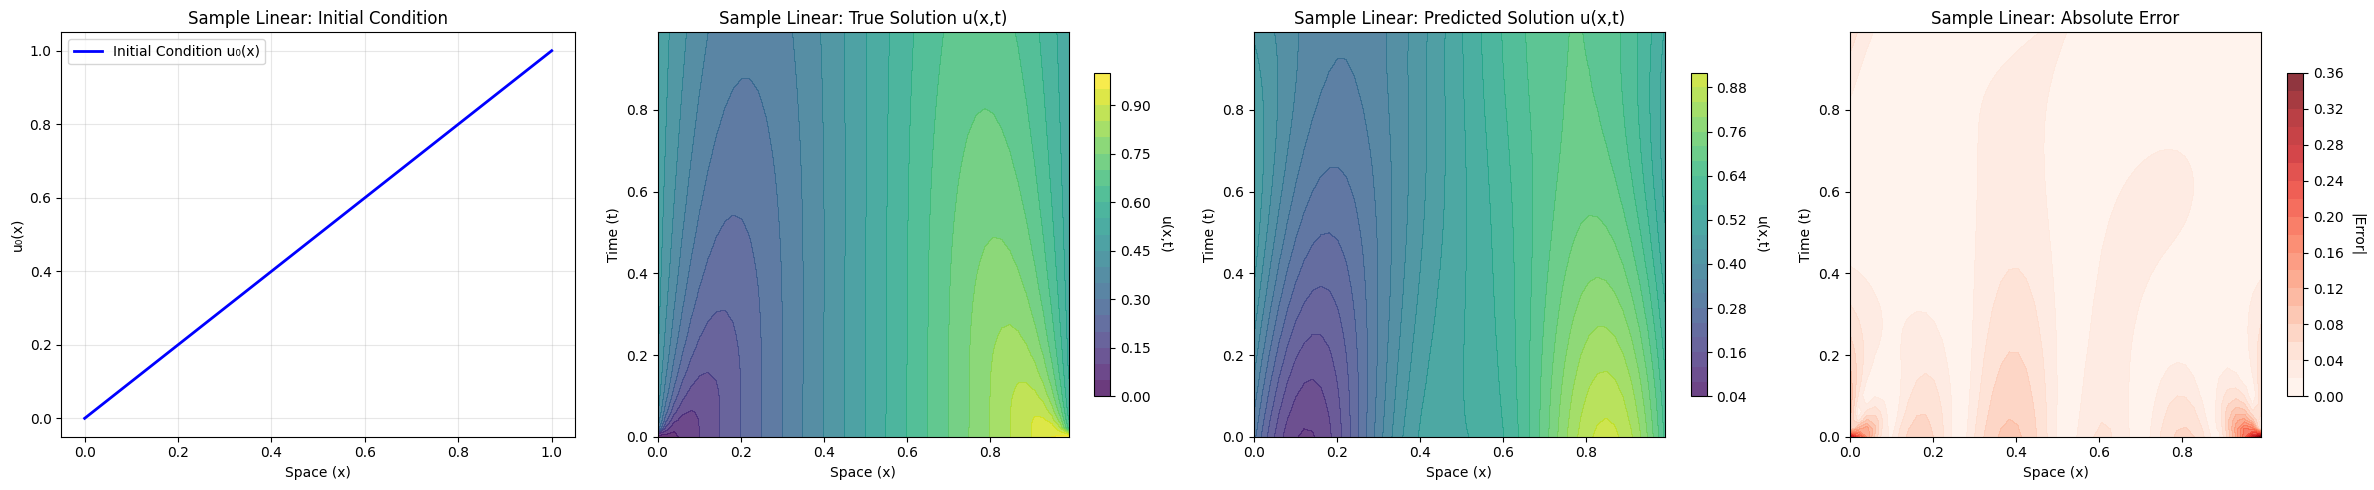

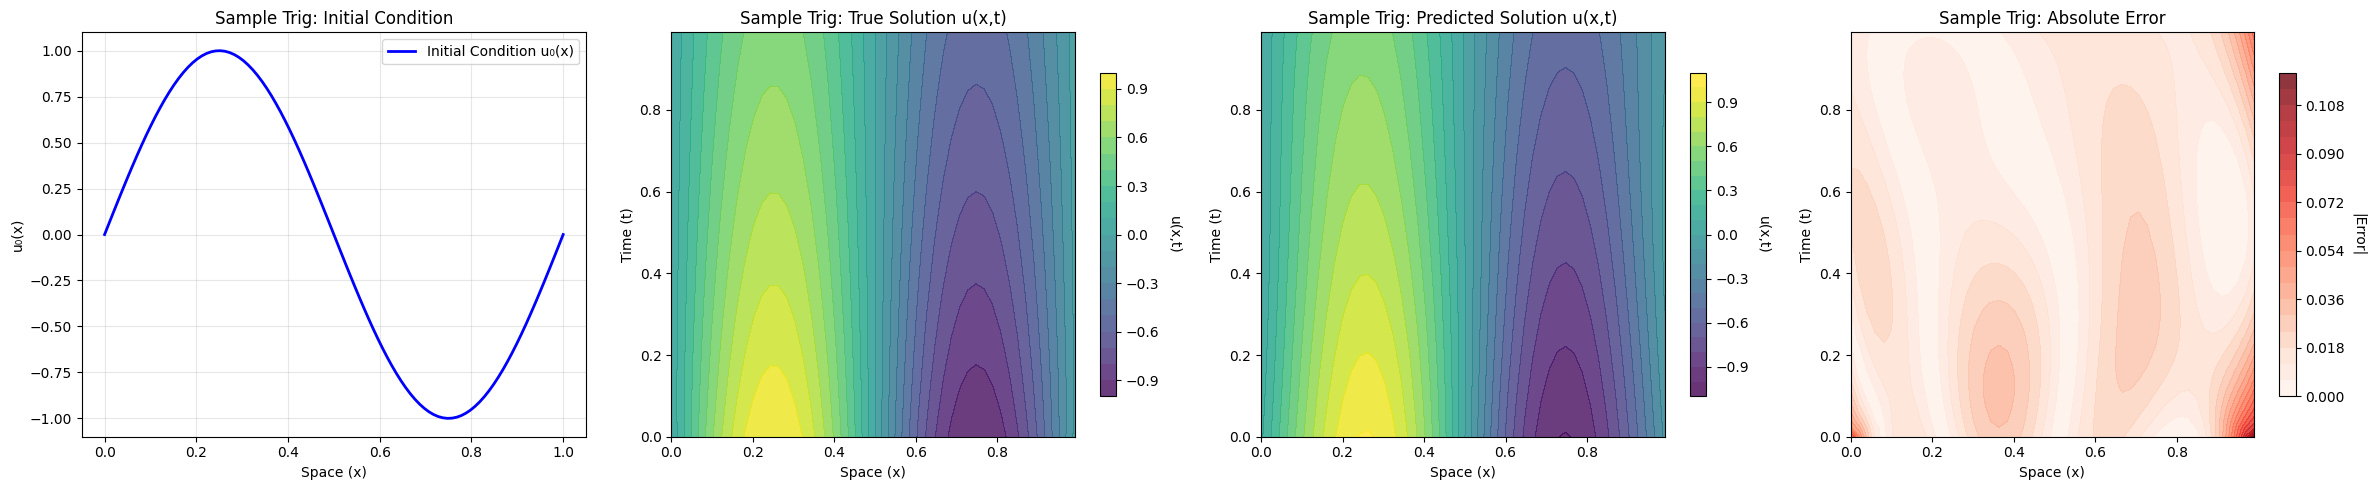


2. 统计摘要:
样本 Linear: MSE=0.000969, MAE=0.022816, 最大误差=0.404684
样本 Trig: MSE=0.000309, MAE=0.014174, 最大误差=0.129816

整体统计: MSE=0.000639, MAE=0.018495, 最大误差=0.404684

结果已保存在: visualization_results/QuanONet/Burgers_Operator_results/
可视化分析完成!


In [6]:
print("开始生成方程真解...")
from data_utils.data_generation import *
func_operator_type = f"solve_{operator_type.lower()}_pde"
solve_func = globals()[func_operator_type]

num_points = config['num_points']
# 创建两种初始条件：线性函数和三角函数
x = np.linspace(0, 1, config["branch_input_size"])
# 线性函数 u0 = x
u0_linear = x
# 三角函数 u0 = sin(π*x)
u0_trig = np.sin(2*np.pi*x)
u0_conditions = {'Linear': u0_linear, 'Trig': u0_trig}
# 选择两种初始条件进行详细对比：线性函数和三角函数
conditions = ['Linear', 'Trig']
results = []
for i, condition in enumerate(conditions):
    u0_condition = u0_conditions[condition]
    # 模型预测
    u_pred_condition = generate_predictions_mindspore(model, u0_condition, num_points=config['num_points'])
    u_solution, u0_cal = solve_func(num_points, length_scale=0.2, u0_cal=u0_condition)
    # 存储结果
    result = {
        'sample_idx': condition,
        'u0': u0_condition,
        'u_true': u_solution,
        'u_pred': u_pred_condition,
        'x_coords': x_coords,
        't_coords': t_coords
    }
    results.append(result)
# 为选定的初始条件绘制对比图
print(f"绘制算子真解与预测解对比图...")
# 生成可视化结果
print("开始生成可视化结果...")
# 1. 为每个样本生成对比图 (包含误差热图)
print("\n1. 生成样本对比图 (四子图布局)...")
for result in results:
    plot_comparison(result, save_path)
# 2. 生成统计摘要
print("\n2. 统计摘要:")
print("="*50)
for i, result in enumerate(results):
    condition = result['sample_idx']
    u_true = result['u_true']
    u_pred = result['u_pred']
    # 计算误差统计
    abs_error = np.abs(u_true - u_pred)
    mse = np.mean((u_true - u_pred)**2)
    mae = np.mean(abs_error)
    max_abs_error = np.max(abs_error)
    print(f"样本 {condition}: MSE={mse:.6f}, MAE={mae:.6f}, 最大误差={max_abs_error:.6f}")
# 计算整体统计
all_true = np.concatenate([result['u_true'].flatten() for result in results])
all_pred = np.concatenate([result['u_pred'].flatten() for result in results])
overall_mse = np.mean((all_true - all_pred)**2)
overall_mae = np.mean(np.abs(all_true - all_pred))
overall_max_error = np.max(np.abs(all_true - all_pred))
print(f"\n整体统计: MSE={overall_mse:.6f}, MAE={overall_mae:.6f}, 最大误差={overall_max_error:.6f}")
print(f"\n结果已保存在: {save_path}/")
print("可视化分析完成!")